# Self-Healing Time Parser Demo

This notebook demonstrates the self-healing time parser system that uses an LLM-based coding agent to automatically update parsing logic when encountering new time expression patterns.


In [1]:
# Path setup
import sys
from pathlib import Path

# Find project root: the directory that contains notebooks/ as a subdirectory
cwd = Path.cwd()

# Start from current directory and walk up until we find a directory with notebooks/ subdirectory
project_root = None
current = cwd
while current != current.parent:  # Stop at filesystem root
    if (current / "notebooks").exists() and (current / "notebooks").is_dir():
        project_root = current
        break
    current = current.parent

# If not found, fallback to current directory
if project_root is None:
    project_root = cwd
    print(f"⚠ Warning: Could not find project root (directory with notebooks/ subdirectory)")
    print(f"   Using current directory as fallback: {project_root}")

# Add project root to path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current working directory: {cwd}")
print(f"Python executable: {sys.executable}")
print(f"Python path includes project root: {str(project_root) in sys.path}")

# Verify coding_agent can be found
try:
    import coding_agent
    print(f"✓ coding_agent module found at: {coding_agent.__file__}")
except ImportError as e:
    print(f"✗ coding_agent module not found: {e}")
    print(f"  Please ensure you're using the correct Python environment where the package is installed.")
    print(f"  Try: uv run jupyter notebook notebooks/demo.ipynb")


Project root: /Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025
Current working directory: /Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025/notebooks
Python executable: /Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025/.venv/bin/python3
Python path includes project root: True
✓ coding_agent module found at: /Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025/coding_agent/__init__.py


In [2]:
from IPython.display import Image, display

In [3]:
# Imports
import json
import logging
import os
import uuid
from datetime import datetime, timezone

import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI

from coding_agent.agent import CodingAgentWorkflow
from coding_agent.base import (
    AnnotationState,
    DEFAULT_RATE_LIMITING_CONFIG,
)
from coding_agent.error_queue import get_error_count, read_error_queue
from coding_agent.llms import NodeLLMs
from coding_agent.prompts import build_node_prompts
from coding_agent.reloader import reload_parser
from coding_agent.test_runner import run_pytest
from time_parser import TimeParser
from time_parser.wrapper import intercept_parser_errors

print("✓ All imports successful")

# Configure pandas display options
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of each column
pd.set_option('display.width', None)  # Auto-detect terminal width
pd.set_option('display.max_rows', 100)  # Show up to 100 rows (adjust as needed)

print("✓ Pandas display options configured for full column width")

✓ All imports successful
✓ Pandas display options configured for full column width


/Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025/coding_agent/llms.py:13: UserWarning: Field name "validate" in "NodeLLMs" shadows an attribute in parent "BaseModel"
  class NodeLLMs(BaseModel):
/Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025/coding_agent/prompts.py:19: UserWarning: Field name "validate" in "NodePrompts" shadows an attribute in parent "BaseModel"
  class NodePrompts(BaseModel):


In [4]:
# Logging configuration
# Set to DEBUG to see LLM input/output when debug_logging=True in workflow
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

print("✓ Logging configured (DEBUG level - will show LLM input/output when debug_logging=True)")


✓ Logging configured (DEBUG level - will show LLM input/output when debug_logging=True)


In [5]:
# Initialize Gemini LLM
api_key = os.getenv("GOOGLE_API_KEY")
if not api_key:
    raise ValueError("GOOGLE_API_KEY environment variable not set")

# Try gemini-3
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-3-pro-preview",
        google_api_key=api_key,
        temperature=0.2,
        max_output_tokens=8192,
    )
    print("✓ Using gemini-3")
    print(f"✓ LLM initialized: gemini-3")
except Exception as e:
    print(f"✗ Failed to initialize gemini-3: {e}")
    raise


✓ Using gemini-3
✓ LLM initialized: gemini-3


## Problem Demonstration

Let's first examine the problem we're trying to solve - some timing descriptions fail to parse while others succeed.


In [6]:
# Load fixture file (use project_root from cell 1)
fixture_path = project_root / "tests" / "fixtures" / "follow_up_tasks_202512121435.jsonl"
if not fixture_path.exists():
    raise FileNotFoundError(f"Fixture file not found: {fixture_path}")
df = pd.read_json(str(fixture_path), lines=True)

print(f"Total rows: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
df.head()


Total rows: 129
Columns: ['customer_id', 'deadline_at', 'timing_description', 'auxiliary_pretty']


,customer_id,deadline_at,timing_description,auxiliary_pretty
0,3,NaT,After the initial service appointment is completed.,"{\n ""parsing_error"": {\n ""error_type"": ""parsing_failed"",\n ""error_message"": ""Could not parse timing description: After the initial service appointment is completed."",\n ""original_timing"": ""After the initial service appointment is completed.""\n },\n ""deadline_parsing"": {\n ""timezone_used"": ""UTC"",\n ""parsing_method"": ""fallback"",\n ""original_timing"": ""After the initial service appointment is completed."",\n ""parsed_timestamp"": null\n }\n}"
1,3,NaT,"As soon as customer obtains pictures, potentially tomorrow as suggested by customer.","{\n ""parsing_error"": {\n ""error_type"": ""parsing_failed"",\n ""error_message"": ""Could not parse timing description: As soon as customer obtains pictures, potentially tomorrow as suggested by customer."",\n ""original_timing"": ""As soon as customer obtains pictures, potentially tomorrow as suggested by customer.""\n },\n ""deadline_parsing"": {\n ""timezone_used"": ""UTC"",\n ""parsing_method"": ""fallback"",\n ""original_timing"": ""As soon as customer obtains pictures, potentially tomorrow as suggested by customer."",\n ""parsed_timestamp"": null\n }\n}"
2,3,NaT,"In 3-5 business days, to allow time for the customer's internal discussion.","{\n ""parsing_error"": {\n ""error_type"": ""parsing_failed"",\n ""error_message"": ""Could not parse timing description: In 3-5 business days, to allow time for the customer's internal discussion."",\n ""original_timing"": ""In 3-5 business days, to allow time for the customer's internal discussion.""\n },\n ""deadline_parsing"": {\n ""timezone_used"": ""UTC"",\n ""parsing_method"": ""fallback"",\n ""original_timing"": ""In 3-5 business days, to allow time for the customer's internal discussion."",\n ""parsed_timestamp"": null\n }\n}"
3,3,NaT,March (or when weather warms up),"{\n ""parsing_error"": {\n ""error_type"": ""parsing_failed"",\n ""error_message"": ""Could not parse timing description: March (or when weather warms up)"",\n ""original_timing"": ""March (or when weather warms up)""\n },\n ""deadline_parsing"": {\n ""timezone_used"": ""UTC"",\n ""parsing_method"": ""fallback"",\n ""original_timing"": ""March (or when weather warms up)"",\n ""parsed_timestamp"": null\n }\n}"
4,3,NaT,"On December 18th, prior to the 4-5 PM appointment window.","{\n ""parsing_error"": {\n ""error_type"": ""parsing_failed"",\n ""error_message"": ""Could not parse timing description: On December 18th, prior to the 4-5 PM appointment window."",\n ""original_timing"": ""On December 18th, prior to the 4-5 PM appointment window.""\n },\n ""deadline_parsing"": {\n ""timezone_used"": ""UTC"",\n ""parsing_method"": ""fallback"",\n ""original_timing"": ""On December 18th, prior to the 4-5 PM appointment window."",\n ""parsed_timestamp"": null\n }\n}"


In [7]:
# Show rows where parsing failed (deadline_at is null)
failed_parses = df[df['deadline_at'].isna()][['customer_id', 'timing_description', 'deadline_at']]
print(f"Rows with parsing failures: {len(failed_parses)}")
print("\nSample parsing failures:")
failed_parses.head(10)


Rows with parsing failures: 71

Sample parsing failures:


,customer_id,timing_description,deadline_at
0,3,After the initial service appointment is completed.,NaT
1,3,"As soon as customer obtains pictures, potentially tomorrow as suggested by customer.",NaT
2,3,"In 3-5 business days, to allow time for the customer's internal discussion.",NaT
3,3,March (or when weather warms up),NaT
4,3,"On December 18th, prior to the 4-5 PM appointment window.",NaT
5,3,By 9 AM on Monday (as promised by the agent).,NaT
6,3,At customer's earliest convenience,NaT
7,3,By 9 AM on Monday (as committed by the agent).,NaT
8,3,"On December 19th, prior to the technician's arrival, which is after 2:30 PM.",NaT
9,3,Monday morning by 9 AM,NaT


In [8]:
# Show rows where parsing succeeded (deadline_at has value)
successful_parses = df[df['deadline_at'].notna()][['customer_id', 'timing_description', 'deadline_at']]
print(f"Rows with successful parses: {len(successful_parses)}")
print("\nSample successful parses:")
successful_parses.head(10)


Rows with successful parses: 58

Sample successful parses:


,customer_id,timing_description,deadline_at
71,3,In 2-3 weeks,2025-12-30 22:26:57.527000+00:00
72,3,tomorrow,2025-12-13 17:20:34.622000+00:00
73,3,tomorrow,2025-12-13 15:36:17.964000+00:00
74,3,today,2025-12-13 07:59:59+00:00
75,3,today,2025-12-13 07:59:59+00:00
76,3,Later today,2025-12-13 07:59:59+00:00
77,3,"Immediately after the call, or same day.",2025-12-13 03:44:24.546000+00:00
78,3,Immediately after the call.,2025-12-13 03:39:04.907000+00:00
79,3,"As soon as possible, ideally within the hour, to secure today's appointment.",2025-12-13 03:39:04.907000+00:00
80,3,Immediately / End of business day,2025-12-13 03:09:06.616000+00:00


In [9]:
# Clear parsers directory (start with empty state)
parsers_dir = Path("time_parser/parsers")
if parsers_dir.exists():
    # Remove all Python files except __init__.py
    for parser_file in parsers_dir.glob("*.py"):
        if parser_file.name != "__init__.py":
            parser_file.unlink()
            print(f"✓ Removed {parser_file.name}")
    print(f"✓ Cleared parsers directory: {parsers_dir}")
else:
    print(f"✓ Parsers directory does not exist yet: {parsers_dir}")



✓ Cleared parsers directory: time_parser/parsers


In [10]:
# Show parsers directory (initially empty)
from pathlib import Path

parsers_dir = Path("time_parser/parsers")
print(f"Parsers directory: {parsers_dir}")
print(f"Exists: {parsers_dir.exists()}")

if parsers_dir.exists():
    parser_files = list(parsers_dir.glob("*.py"))
    print(f"Parser modules: {[f.name for f in parser_files if f.name != '__init__.py']}")
else:
    print("Parsers directory does not exist yet")


Parsers directory: time_parser/parsers
Exists: True
Parser modules: []


In [11]:
# Create and test initial parser
parser = TimeParser()

# Test with basic inputs
test_inputs = ["asap", "now", "tomorrow"]

print("Testing initial parser:")
for input_text in test_inputs:
    try:
        result = parser.parse(input_text)
        print(f"✓ Parsed '{input_text}': {result}")
    except ValueError as e:
        print(f"✗ Failed to parse '{input_text}': {e}")


Testing initial parser:
✓ Parsed 'asap': 2025-12-14 02:31:34.068873+00:00
✓ Parsed 'now': 2025-12-14 02:31:34.068905+00:00
✗ Failed to parse 'tomorrow': Could not parse time expression: tomorrow


## Error Collection

Now let's wrap the parser with the exception interceptor to automatically log parsing failures to the error queue.


In [12]:
# Clean up any existing error queue
error_queue_path = Path("error_queue.jsonl")
if error_queue_path.exists():
    error_queue_path.unlink()
    print("✓ Cleared existing error queue")

# Wrap parser with exception interceptor
wrapped_parse = intercept_parser_errors(
    parser,
    queue_path=str(error_queue_path),
)(parser.parse)

print("✓ Parser wrapped with exception interceptor")


✓ Cleared existing error queue
✓ Parser wrapped with exception interceptor


In [13]:
# Test parser with various inputs that will fail
test_inputs = [
    "tomorrow",
    "next week",
    "in 2 days",
    "Monday morning",
    "By 9 AM on Monday",
    "Within 1-2 business days",
    "After the initial service appointment is completed",
]

print("Testing parser with various inputs (errors will be logged):")
for input_text in test_inputs:
    try:
        result = wrapped_parse(input_text)
        print(f"✓ Parsed '{input_text}': {result}")
    except ValueError as e:
        print(f"✗ Failed to parse '{input_text}' (logged to error queue)")


Testing parser with various inputs (errors will be logged):
✗ Failed to parse 'tomorrow' (logged to error queue)
✗ Failed to parse 'next week' (logged to error queue)
✗ Failed to parse 'in 2 days' (logged to error queue)
✗ Failed to parse 'Monday morning' (logged to error queue)
✗ Failed to parse 'By 9 AM on Monday' (logged to error queue)
✗ Failed to parse 'Within 1-2 business days' (logged to error queue)
✗ Failed to parse 'After the initial service appointment is completed' (logged to error queue)


In [14]:
# Display error queue contents
errors = read_error_queue(error_queue_path)
print(f"Total errors in queue: {len(errors)}")
print("\nSample errors:")
for i, error in enumerate(errors[:5]):
    print(f"{i+1}. {error.get('timing_description', 'N/A')}")


Total errors in queue: 7

Sample errors:
1. tomorrow
2. next week
3. in 2 days
4. Monday morning
5. By 9 AM on Monday


**Preview: The REASON node will cluster these errors by semantic similarity. For example:**
- **Relative dates cluster**: "tomorrow", "next week", "in 2 days", "Monday morning"
- **Specific dates with times cluster**: "By 9 AM on Monday"
- **Time ranges cluster**: "Within 1-2 business days"
- **Context-dependent cluster**: "After the initial service appointment is completed"


## Agent Activation

Now let's activate the coding agent to analyze errors, generate parser modules, and update the parser automatically.


In [15]:
# Check error count threshold
error_count = get_error_count(error_queue_path)
print(f"Errors in queue: {error_count}")

from coding_agent.config import ERROR_THRESHOLD
print(f"Error threshold: {ERROR_THRESHOLD}")

if error_count >= ERROR_THRESHOLD:
    print("✓ Enough errors to activate agent")
else:
    print(f"⚠ Need at least {ERROR_THRESHOLD} errors to activate agent")


Errors in queue: 7
Error threshold: 5
✓ Enough errors to activate agent


In [16]:
# Build NodePrompts
node_prompts = build_node_prompts()
print("✓ NodePrompts created (template user prompts, not formatted)")

# Build NodeLLMs
node_llms = NodeLLMs(reason=llm, plan=llm, act=llm, validate=llm)
print("✓ NodeLLMs configured")

# Generate thread_id
thread_id = f"coding_agent_{uuid.uuid4().hex[:8]}"
print(f"✓ Thread ID: {thread_id}")


✓ NodePrompts created (template user prompts, not formatted)
✓ NodeLLMs configured
✓ Thread ID: coding_agent_5826480b


In [17]:
# Initialize CodingAgentWorkflow
workflow = CodingAgentWorkflow(
    node_llms=node_llms,
    node_prompts=node_prompts,  # Template prompts, not formatted
    thread_id=thread_id,
    error_queue_path="error_queue.jsonl",
    parsers_dir="time_parser/parsers",
    tests_dir="time_parser/tests",
    rate_limiting_config=DEFAULT_RATE_LIMITING_CONFIG,
    fail_fast=False,
    error_logging=True,
    debug_logging=True,
    enforce_structured_llm_output=False,  # Must be False for schema=None
)

print("✓ CodingAgentWorkflow initialized")


✓ CodingAgentWorkflow initialized


2025-12-13 18:31:38,978 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-12-13 18:31:39,274 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXJlYXNvbihyZWFzb24pCglwbGFuKHBsYW4pCglhY3QoYWN0KQoJdmFsaWRhdGUodmFsaWRhdGUpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiByZWFzb247CglhY3QgLS4gJm5ic3A7ZXhpdCZuYnNwOyAuLT4gX19lbmRfXzsKCWFjdCAtLiAmbmJzcDtjb250aW51ZSZuYnNwOyAuLT4gdmFsaWRhdGU7CglwbGFuIC0uICZuYnNwO2V4aXQmbmJzcDsgLi0+IF9fZW5kX187CglwbGFuIC0uICZuYnNwO2NvbnRpbnVlJm5ic3A7IC4tPiBhY3Q7CglyZWFzb24gLS4gJm5ic3A7ZXhpdCZuYnNwOyAuLT4gX19lbmRfXzsKCXJlYXNvbiAtLiAmbmJzcDtjb250aW51ZSZuYnNwOyAuLT4gcGxhbjsKCXZhbGlkYXRlIC0uICZuYnNwO2ZhaWx1cmUmbmJzcDsgLi0+IF9fZW5kX187Cgl2YWxpZGF0ZSAtLiAmbmJzcDtyZXRyeSZuYnNwOyAuLT4gcGxhbjsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZ

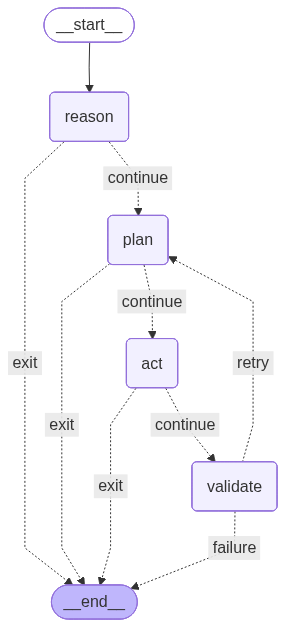

In [18]:
display(Image(workflow.graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
# Create initial state
initial_state = AnnotationState(
    messages=[],
    node_output=None,
    final_output=None,
)

print("✓ Initial state created")


✓ Initial state created


In [20]:
# Run agent workflow
print("Running coding agent workflow...")
print("This will:")
print("  1. REASON: Cluster errors by semantic similarity")
print("  2. PLAN: Design code changes and test strategy")
print("  3. ACT: Generate parser modules and test files")
print("  4. VALIDATE: Run tests and verify all pass")
print()

result = workflow.run(initial_state=initial_state)

print("\n✓ Workflow completed!")
print(f"Result keys: {list(result.keys())}")

# Diagnostic: Check why final_output might be empty
if not result or len(result) == 0:
    print("\n⚠️  DIAGNOSTIC: final_output is empty!")
    print("Checking workflow state...")
    try:
        final_state = workflow.get_state()
        if hasattr(final_state, 'values'):
            node_output = final_state.values.get("node_output", {})
            final_output = final_state.values.get("final_output", None)
            
            print(f"  - final_output in state: {final_output is not None}")
            if final_output:
                print(f"  - final_output keys: {list(final_output.keys())}")
            
            print(f"  - node_output keys: {list(node_output.keys()) if node_output else 'None'}")
            
            # Check for early exit flags
            if node_output:
                early_exit = node_output.get("early_exit", False)
                print(f"  - early_exit flag: {early_exit}")
                
                if early_exit:
                    print("  → Workflow exited early (likely no errors or no clusters selected)")
                
                # Check which node might have caused early exit
                if "error_clusters" in node_output:
                    clusters = node_output.get("error_clusters", [])
                    print(f"  - Error clusters found: {len(clusters)}")
                
                if "selected_clusters" in node_output:
                    selected = node_output.get("selected_clusters", [])
                    print(f"  - Selected clusters: {len(selected)} ({selected})")
                
                if "test_results" in node_output:
                    test_results = node_output.get("test_results", {})
                    all_passed = test_results.get("all_passed", None)
                    print(f"  - Test results available: {test_results is not None}")
                    print(f"  - All tests passed: {all_passed}")
                
                retry_count = node_output.get("retry_count", 0)
                print(f"  - Retry count: {retry_count}")
                
                if "error" in node_output:
                    print(f"  - Error in node_output: {node_output['error']}")
        else:
            print("  - Could not access state values")
    except Exception as e:
        print(f"  - Error accessing state: {e}")


2025-12-13 18:31:41,870 - utils.llm_helpers - DEBUG - 
[Node=Node=reason] LLM Input:
----------------------------------------
System Prompt:

You are an expert in natural language time expression parsing and pattern recognition.

Your task is to analyze a collection of parsing errors and cluster them into groups of similar patterns. Each cluster represents a class of time expressions that can be handled by a single parsing module.

## Context

We are building a self-healing time parser system. When the parser encounters time expressions it cannot parse, those errors are logged to a queue file. Your job is to identify common patterns among these errors so that we can generate efficient parsing code that handles multiple similar cases at once.

## Clustering Principles

1. **Semantic Similarity**: Group errors that represent similar time expression patterns, even if the exact wording differs
   - Example: "tomorrow", "next week", "in 2 days" → all relative date expressions
   - Example: 

Running coding agent workflow...
This will:
  1. REASON: Cluster errors by semantic similarity
  2. PLAN: Design code changes and test strategy
  3. ACT: Generate parser modules and test files
  4. VALIDATE: Run tests and verify all pass



2025-12-13 18:32:08,401 - httpcore.http11 - DEBUG - receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json; charset=UTF-8'), (b'Vary', b'Origin'), (b'Vary', b'X-Origin'), (b'Vary', b'Referer'), (b'Content-Encoding', b'gzip'), (b'Date', b'Sun, 14 Dec 2025 02:32:08 GMT'), (b'Server', b'scaffolding on HTTPServer2'), (b'X-XSS-Protection', b'0'), (b'X-Frame-Options', b'SAMEORIGIN'), (b'X-Content-Type-Options', b'nosniff'), (b'Server-Timing', b'gfet4t7; dur=26108'), (b'Alt-Svc', b'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'), (b'Transfer-Encoding', b'chunked')])
2025-12-13 18:32:08,404 - httpx - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-3-pro-preview:generateContent "HTTP/1.1 200 OK"
2025-12-13 18:32:08,406 - httpcore.http11 - DEBUG - receive_response_body.started request=<Request [b'POST']>
2025-12-13 18:32:08,410 - httpcore.http11 - DEBUG - receive_response_body.complete
2025-12-13 18


✓ Workflow completed!
Result keys: ['success', 'processed_clusters', 'errors_removed_count', 'parser_updated', 'tests_passed', 'retry_count', 'message', 'test_results', 'cluster_error_indices', 'generated_cluster_modules', 'generated_test_files']


In [21]:
# Display agent results
print("Agent Results:")
print(f"  Success: {result.get('success', False)}")
print(f"  Processed clusters: {result.get('processed_clusters', [])}")
print(f"  Errors removed: {result.get('errors_removed_count', 0)}")
print(f"  Parser updated: {result.get('parser_updated', False)}")
print(f"  Tests passed: {result.get('tests_passed', False)}")
print(f"  Retry count: {result.get('retry_count', 0)}")
print(f"  Generated modules: {list(result.get('generated_cluster_modules', {}).keys())}")
print(f"  Generated test files: {list(result.get('generated_test_files', {}).keys())}")

if result.get('message'):
    print(f"  Message: {result['message']}")


Agent Results:
  Success: False
  Processed clusters: ['relative_time_offsets', 'weekday_time_constraints', 'business_day_ranges']
  Errors removed: 0
  Parser updated: False
  Tests passed: False
  Retry count: 3
  Generated modules: ['relative_time_offsets', 'weekday_time_constraints', 'business_day_ranges']
  Generated test files: ['relative_time_offsets', 'weekday_time_constraints', 'business_day_ranges']
  Message: Max retries (3) reached. Tests did not pass after 3 attempts.


In [22]:
from diagnose_and_fix import diagnose_from_result

# Use your existing result
diagnose_from_result(result)

DIAGNOSIS: Why tests failed

1. Code Generation Status:
   Generated modules: 3
   Generated test files: 3
   Module names: ['relative_time_offsets', 'weekday_time_constraints', 'business_day_ranges']
   Test file names: ['relative_time_offsets', 'weekday_time_constraints', 'business_day_ranges']

2. Files on Disk:
   Parser modules on disk: 3
   Files: ['relative_time_offsets.py', 'business_day_ranges.py', 'weekday_time_constraints.py']
   Test files on disk: 17
   Files: ['test_specific_dates.py', 'test_specific_deadlines.py', 'test_specific_weekday_deadline.py', 'test_weekday_time_constraints.py', 'test_business_day_ranges.py', 'test_specific_time_deadlines.py', 'test_general_relative_dates.py', 'test_relative_dates.py', 'test_weekday_time_expressions.py', 'test_specific_deadline_times.py', 'test_business_days_range.py', 'test_relative_time_offsets.py', 'test_weekday_expressions.py', 'test_relative_time_expressions.py', 'test_business_day_durations.py', 'test_specific_deadline_with_

In [23]:
from recover_and_test import write_generated_code_to_disk, run_tests_and_reload

# Write the generated test files to disk (modules are already there)
write_generated_code_to_disk(
    result["generated_cluster_modules"],
    result["generated_test_files"],
    parsers_dir="notebooks/time_parser/parsers",
    tests_dir="notebooks/time_parser/tests"
)

# Run tests
test_results = run_tests_and_reload(
    tests_dir="notebooks/time_parser/tests",
    parsers_dir="notebooks/time_parser/parsers"
)

print(f"\n✅ Tests passed: {test_results['all_passed']}")


📝 Writing 3 parser modules to notebooks/time_parser/parsers...
  ✓ Wrote notebooks/time_parser/parsers/relative_time_offsets.py
  ✓ Wrote notebooks/time_parser/parsers/weekday_time_constraints.py
  ✓ Wrote notebooks/time_parser/parsers/business_day_ranges.py

📝 Writing 3 test files to notebooks/time_parser/tests...
  ✓ Wrote notebooks/time_parser/tests/test_relative_time_offsets.py
  ✓ Wrote notebooks/time_parser/tests/test_weekday_time_constraints.py
  ✓ Wrote notebooks/time_parser/tests/test_business_day_ranges.py

🧪 Running tests in notebooks/time_parser/tests...

Test Results:
  All passed: False
  Return code: 2

Test Output:
============================= test session starts ==============================
platform darwin -- Python 3.11.11, pytest-9.0.2, pluggy-1.6.0 -- /Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025/.venv/bin/python3
cachedir: .pytest_cache
rootdir: /Users/alexsherstinsky/Develo

In [24]:
from recover_and_test import write_generated_code_to_disk, run_tests_and_reload

# Write to the CORRECT location (time_parser/, not notebooks/time_parser/)
write_generated_code_to_disk(
    result["generated_cluster_modules"],
    result["generated_test_files"],
    parsers_dir="time_parser/parsers",  # Correct location
    tests_dir="time_parser/tests"       # Correct location
)

# Run tests from correct location
test_results = run_tests_and_reload(
    tests_dir="time_parser/tests",
    parsers_dir="time_parser/parsers"
)

print(f"\n✅ Tests passed: {test_results['all_passed']}")


📝 Writing 3 parser modules to time_parser/parsers...
  ✓ Wrote time_parser/parsers/relative_time_offsets.py
  ✓ Wrote time_parser/parsers/weekday_time_constraints.py
  ✓ Wrote time_parser/parsers/business_day_ranges.py

📝 Writing 3 test files to time_parser/tests...
  ✓ Wrote time_parser/tests/test_relative_time_offsets.py
  ✓ Wrote time_parser/tests/test_weekday_time_constraints.py
  ✓ Wrote time_parser/tests/test_business_day_ranges.py

🧪 Running tests in time_parser/tests...

Test Results:
  All passed: True
  Return code: 0

Test Output:
============================= test session starts ==============================
platform darwin -- Python 3.11.11, pytest-9.0.2, pluggy-1.6.0 -- /Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hackathon_12132025/.venv/bin/python3
cachedir: .pytest_cache
rootdir: /Users/alexsherstinsky/Development/MustExist/ConvoScience/AGI_HOUSE_GEMINI_3_HACKATHON_12132025/agi_house_gemini_3_hacka

## Success Verification

Let's verify that the parser now works with previously failing inputs and check the test results.


In [ ]:
# Reload parser after agent update
parser = reload_parser("time_parser/parsers")
print("✓ Parser reloaded with updated cluster modules")

# Show updated parsers directory
parsers_dir = Path("time_parser/parsers")
if parsers_dir.exists():
    parser_files = list(parsers_dir.glob("*.py"))
    print(f"Parser modules: {[f.name for f in parser_files if f.name != '__init__.py']}")


In [ ]:
# Test parser with previously failing inputs
previously_failing = [
    "tomorrow",
    "next week",
    "in 2 days",
    "Monday morning",
]

print("Testing parser with previously failing inputs:")
for input_text in previously_failing:
    try:
        result = parser.parse(input_text)
        print(f"✓ Parsed '{input_text}': {result}")
    except ValueError as e:
        print(f"✗ Still failed to parse '{input_text}': {e}")


In [ ]:
# Run pytest and display results
test_results = run_pytest("time_parser/tests", verbose=True)

print(f"All tests passed: {test_results['all_passed']}")
print(f"Return code: {test_results['returncode']}")
print(f"\nTest output:\n{test_results['test_output']}")

if test_results['test_errors']:
    print(f"\nTest errors:\n{test_results['test_errors']}")


In [ ]:
# Show updated error queue (should have fewer errors)
remaining_errors = read_error_queue(error_queue_path)
print(f"Remaining errors in queue: {len(remaining_errors)}")
print(f"Errors removed: {result.get('errors_removed_count', 0)}")

if remaining_errors:
    print("\nRemaining errors (not yet processed):")
    for i, error in enumerate(remaining_errors[:5]):
        print(f"  {i+1}. {error.get('timing_description', 'N/A')}")
else:
    print("\n✓ All errors have been processed!")


## Real Production Data Validation

Now let's validate the system with real production data from the fixture file. This demonstrates that the self-healing parser works not just with controlled test inputs, but also with actual production failures.



In [ ]:
# Clear error queue again for production data validation
if error_queue_path.exists():
    error_queue_path.unlink()
    print("✓ Cleared error queue for production data validation")
else:
    print("✓ Error queue already empty")



In [ ]:
# Load fixture data and populate error queue with real production failures
from coding_agent.error_queue import append_error_to_queue

# Use project_root from cell 1 for fixture path
fixture_path = project_root / "tests" / "fixtures" / "follow_up_tasks_202512121435.jsonl"
if not fixture_path.exists():
    raise FileNotFoundError(f"Fixture file not found: {fixture_path}")
df_production = pd.read_json(str(fixture_path), lines=True)

# Filter for rows where deadline_at is null (parsing failures)
failed_parses_production = df_production[df_production['deadline_at'].isna()]

print(f"Total rows in fixture: {len(df_production)}")
print(f"Rows with parsing failures: {len(failed_parses_production)}")

# Add production errors to error queue
errors_added = 0
for _, row in failed_parses_production.iterrows():
    error_entry = {
        "customer_id": row.get('customer_id'),
        "deadline_at": None,
        "timing_description": row.get('timing_description'),
        "auxiliary_pretty": row.get('auxiliary_pretty', '{}'),
    }
    
    # Validate timing_description is a non-empty string
    timing_desc = error_entry.get('timing_description', '')
    if isinstance(timing_desc, str) and timing_desc.strip():
        append_error_to_queue(str(error_queue_path), error_entry)
        errors_added += 1

print(f"✓ Added {errors_added} production errors to error queue")



In [ ]:
# Display sample production errors in queue
production_errors = read_error_queue(error_queue_path)
print(f"Total production errors in queue: {len(production_errors)}")
print("\nSample production errors:")
for i, error in enumerate(production_errors[:10]):
    timing_desc = error.get('timing_description', 'N/A')
    print(f"  {i+1}. {timing_desc}")



In [ ]:
# Check if we have enough errors to run the agent
production_error_count = get_error_count(error_queue_path)
print(f"Production errors in queue: {production_error_count}")
print(f"Error threshold: {ERROR_THRESHOLD}")

if production_error_count >= ERROR_THRESHOLD:
    print("✓ Enough production errors to activate agent")
    print("\nNote: You can run the agent workflow again to process these production errors.")
    print("The workflow would cluster these real production patterns and generate")
    print("parser modules to handle them, just as it did with the controlled test inputs.")
else:
    print(f"⚠ Need at least {ERROR_THRESHOLD} errors to activate agent")
    print(f"   (Current: {production_error_count})")



**Optional: Run Agent on Production Data**

The cell below can be executed to process the production errors through the agent workflow. This demonstrates the full cycle with real production data. (You can skip this if you've already demonstrated the workflow above.)



In [ ]:
# OPTIONAL: Run agent workflow on production errors
# Uncomment the code below to process production errors through the agent

# if production_error_count >= ERROR_THRESHOLD:
#     # Generate new thread_id for this run
#     production_thread_id = f"coding_agent_production_{uuid.uuid4().hex[:8]}"
#     
#     # Initialize workflow (reuse same configuration)
#     production_workflow = CodingAgentWorkflow(
#         node_llms=node_llms,
#         node_prompts=node_prompts,
#         thread_id=production_thread_id,
#         error_queue_path="error_queue.jsonl",
#         parsers_dir="time_parser/parsers",
#         tests_dir="time_parser/tests",
#         rate_limiting_config=DEFAULT_RATE_LIMITING_CONFIG,
#         fail_fast=False,
#         error_logging=True,
#         debug_logging=False,
#         enforce_structured_llm_output=False,
#     )
#     
#     # Create initial state
#     production_initial_state = AnnotationState(
#         messages=[],
#         node_output=None,
#         final_output=None,
#     )
#     
#     # Run workflow
#     print("Running agent workflow on production errors...")
#     production_result = production_workflow.run(initial_state=production_initial_state)
#     
#     print("\n✓ Production workflow completed!")
#     print(f"Success: {production_result.get('success', False)}")
#     print(f"Processed clusters: {production_result.get('processed_clusters', [])}")
#     print(f"Errors removed: {production_result.get('errors_removed_count', 0)}")
#     
#     # Reload parser and test with production patterns
#     parser = reload_parser("time_parser/parsers")
#     print("\n✓ Parser reloaded with production-generated modules")
# else:
#     print("Not enough errors to run agent workflow")

print("(Cell is commented out - uncomment to run agent on production data)")



## Summary

The self-healing time parser system has successfully:
1. ✅ Collected parsing failures in the error queue
2. ✅ Clustered errors by semantic similarity
3. ✅ Generated parser modules for each error cluster
4. ✅ Created comprehensive test files
5. ✅ Validated all tests pass
6. ✅ Updated the parser with new capabilities
7. ✅ Removed processed errors from the queue

The parser can now handle previously failing time expressions automatically!
